# How to Lie with Statistics

Large amounts of data are summarized in many ways, but some summaries can be very misleading. Many datasets may share multiple common statistics such as mean, standard deviation, or correlation, but they may still be clearly distinct from one another in other ways. We will demonstrate that this is the case by showing different methods to transform one dataset to appear like another, while still keeping the same summary statistics.

This notebook's goal is to apply the methods used in [Same Stats, Different Graphs](http://dx.doi.org/10.1145/3025453.3025912) by Justin Matejka and George Fitzmaurice at Autodesk Research, and make improvement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import time

plt.rcParams['text.usetex'] = True

## Direct Method

We begin by first generating some random 2D datasets for testing

In [2]:
def gen_dataset(f, N, noise=[0, 0], dom=[10, 90]):
    """
    Simple utility function to generate `N` random points
    according to `f`, with some added `noise`.
    """
    X = np.linspace(dom[0], dom[1], N)
    Y = f(np.copy(X))
    return np.vstack([
        X + np.random.uniform(-noise[0], noise[0], N),
        Y + np.random.uniform(-noise[1], noise[1], N),
    ]).transpose()

def summary_statistics(data):
    """ Returns the basic 5 summary statistics of `N x 2 data` """
    X, Y = data[:, 0], data[:, 1]
    return np.array([
        np.mean(X),
        np.mean(Y),
        np.std(X),
        np.std(Y),
        np.corrcoef(X, Y)[0, 1]
    ])

def plot_data(data):
    plt.scatter(data[:, 0], data[:, 1])
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect("equal")

def plot_summary(data):
    x_mean, y_mean, x_std, y_std, r = summary_statistics(data)
    plt.text(105, 90,
            f"X Mean: {x_mean:.2f}\nY Mean: {y_mean:.2f}\nX Std: {x_std:.2f}\nY Std: {y_std:.2f}\nR: {r:.2f}",
            verticalalignment="top")

Here are some examples of randomly generated datasets

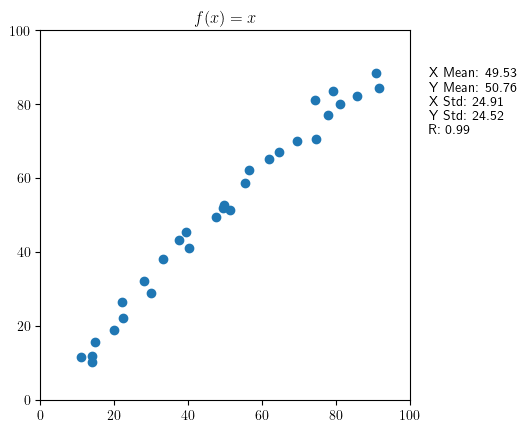

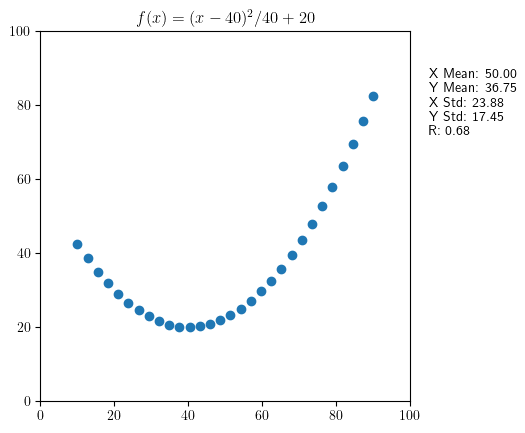

In [3]:
data = gen_dataset(lambda x: x, 30, noise=[5, 5])
plt.title(r"$f(x) = x$")
plot_summary(data)
plot_data(data)
plt.show()

data = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 30)
plt.title(r"$f(x) = (x - 40)^2 / 40 + 20$")
plot_summary(data)
plot_data(data)
plt.show()

Our method will be simple: randomly shift a point in a starting dataset such that the point moves "closer" to our target dataset, ensuring that our summary statistics do not change according to a small tolerance. 

This means that we need to define a heuristic to measure how similar two datasets are.  We will first do the simple approach of just getting the distance between the shifted point and its closest point in the target dataset.

In [4]:
def point_distance(point, target):
    """ Squared distance of `point` to closest point in `target` """
    return np.min(np.sum((target - point[np.newaxis, :]) ** 2, axis=1))

When we `perturb` the dataset, we shift a point such that it gets closer to the target, ignoring restrictions on datasets. We will add a `temp` parameter that will allow such a shift even if it does not get close. This `temp` will start high and end low in our training process, which avoids the dataset converging to a local minimum. We will decrease the temperature using a sigmoid decay function.

In [5]:
def perturb_naive(data, target, ds, temp):
    while True:
        i = np.random.randint(data.shape[0])
        old_dist = point_distance(data[i, :], target)
        new_point = data[i, :] + (np.random.randn(2) * ds)
        new_dist = point_distance(new_point, target)
        if new_dist < old_dist or temp > np.random.uniform():
            data = np.copy(data)
            data[i, :] = new_point
            return data
        
def get_sigmoid_decay(max, min):
    """ Sigmoid decay from `max` to `min` on the domain [0, 1] """
    return lambda x: min + (max - min) / (1 + np.exp(10 * x - 5))


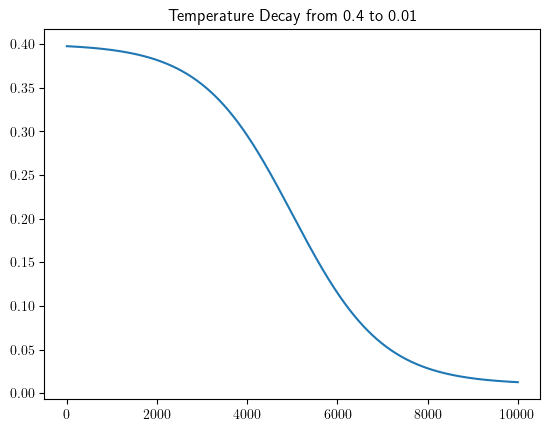

In [6]:
iters = 10000
decay = get_sigmoid_decay(0.4, 0.01)
X = np.arange(1, iters + 1)
Y = decay(X / iters)
plt.title("Temperature Decay from 0.4 to 0.01")
plt.plot(X, Y)
plt.show()

And finally, we assemble the training function! We set our tolerance such that the resulting statistics is the same up to the hundredths place.

In [7]:
def train(source, target, N, perturb, disp_time=True):
    source = source.copy()
    source_stats = np.round(summary_statistics(source), decimals=2) 
    decay = get_sigmoid_decay(0.4, 0.01)

    start = time.time()
    count = 0
    gap = N // 5
    for i in range(1, N + 1):
        perturbed_source = perturb(source, target, ds=0.1, temp=decay(i / N))
        perturbed_stats = np.round(summary_statistics(perturbed_source), decimals=2) 
        if np.all(source_stats == perturbed_stats):
            source = perturbed_source
            count += 1
        if disp_time and i % gap == 0:
            print(f"Iter {i}: ({time.time() - start:.2f} s), {count}/{gap} perturbed")
            count = 0

    return source

Let's test our function using an example dataset!

In [24]:
def plot_trained_data(source, target, result):
    plt.subplots(1, 2, figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Initial Distribution")
    plot_data(target)
    plot_data(source)
    plot_summary(source)

    plt.subplot(1, 2, 2)
    plt.title("Final Distribution")
    plot_data(target)
    plot_data(result)
    plot_summary(result)

    plt.tight_layout(pad=3.0)
    plt.show()

Iter 80000: (5.32 s), 36580/80000 perturbed
Iter 160000: (10.63 s), 31968/80000 perturbed
Iter 240000: (16.10 s), 22608/80000 perturbed
Iter 320000: (21.78 s), 8526/80000 perturbed
Iter 400000: (27.64 s), 3120/80000 perturbed


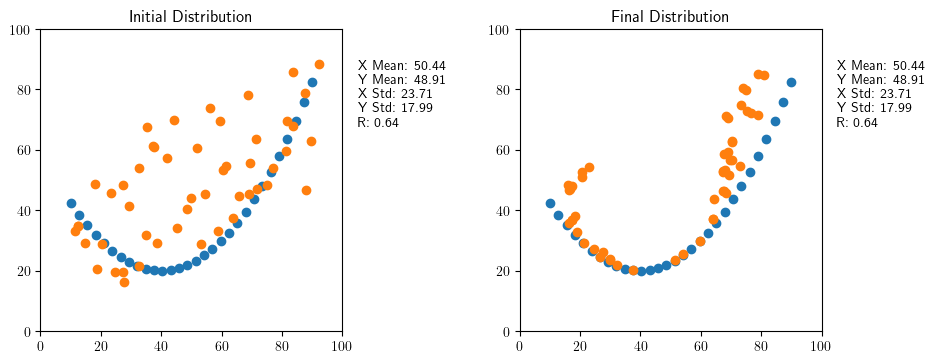

In [25]:
source = gen_dataset(lambda x: 25 + x / 2, 50, noise=[3, 25])
target = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 30)
result = train(source, target, 400_000, perturb=perturb_naive)

plot_trained_data(source, target, result)

# TODO

Different distance metric

In [27]:
def data_distance(source, target):
    """
    Measures distance between two datasets by pairing points such that
    the total distance between each pair of points is minimized.
    The sum of the distances between each pair of points is returned.
    """
    dists = cdist(source, target)
    row_i, col_i = linear_sum_assignment(dists)
    return np.sum(dists[row_i, col_i])

In [28]:
data1 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 30, noise=[1, 1])
data2 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 30, noise=[1, 1])
dist = data_distance(data1, data2)
print("Distance between similar datasets:", dist)

data1 = gen_dataset(lambda x: x, 30)
data2 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 30)
dist = data_distance(data1, data2)
print("Distance between different datasets:", dist)

data1 = gen_dataset(lambda x: x, 30, noise=[1, 1], dom=[10, 50])
data2 = gen_dataset(lambda x: x, 30, noise=[1, 1], dom=[50, 90])
dist = data_distance(data1, data2)
print("Distance between different domains:", dist)

Distance between similar datasets: 29.007012904147743
Distance between different datasets: 601.4447086801426
Distance between different domains: 1706.3713394305373


In [29]:
def perturb_data_distance(data, target, ds, temp):
    data = np.copy(data)
    while True:
        i = np.random.randint(data.shape[0])
        old_dist = data_distance(data, target)
        old_point = data[i, :].copy()
        data[i, :] += np.random.randn(2) * ds
        new_dist = data_distance(data, target)
        if new_dist < old_dist or temp > np.random.uniform():
            return data
        data[i, :] = old_point

Iter 80000: (7.53 s), 24427/80000 perturbed
Iter 160000: (15.42 s), 22921/80000 perturbed
Iter 240000: (24.10 s), 18122/80000 perturbed
Iter 320000: (33.83 s), 9099/80000 perturbed
Iter 400000: (44.02 s), 4141/80000 perturbed


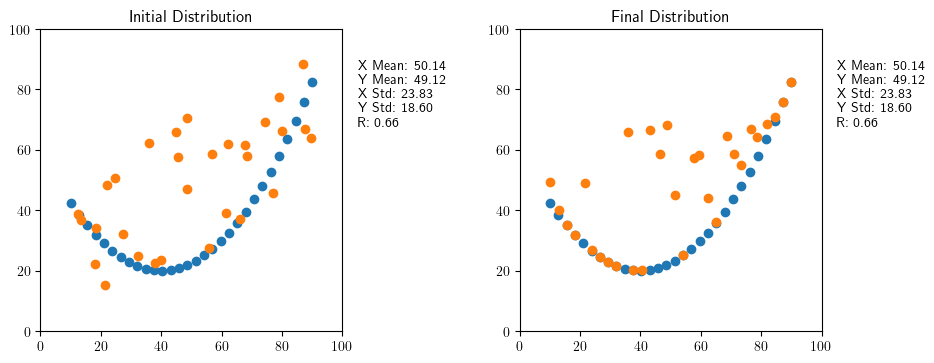

In [36]:
source = gen_dataset(lambda x: 25 + x / 2, 30, noise=[3, 25])
target = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 30)
result = train(source, target, 400_000, perturb=perturb_data_distance)

plot_trained_data(source, target, result)